In [1]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import InMemorySaver

from langchain_openai import ChatOpenAI
from langchain.messages import RemoveMessage

from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
model = ChatOpenAI()

In [5]:
# Define Chat Node
def chat(state: MessagesState):
    response = model.invoke(state['messages'])
    return {"messages": [response]}

In [6]:
# Define Delete old messages node
def delete_old_messages(state: MessagesState):
    msgs = state['messages']
    
    # if more than 10 messages, delete the earliest 6
    if len(msgs) > 10:
        to_remove = msgs[:6]
        return {"messages": [RemoveMessage(id=m.id) for m in to_remove]}
    
    return {}

In [7]:
# Build the graph
builder = StateGraph(MessagesState)

builder.add_node("chat_node", chat)
builder.add_node("cleanup", delete_old_messages)

builder.add_edge(START, "chat_node")
builder.add_edge("chat_node", "cleanup") # run deletion after each response
builder.add_edge("cleanup", END)

# Checkpointer
checkpointer = InMemorySaver()

# Compile the graph
graph = builder.compile(checkpointer=checkpointer)

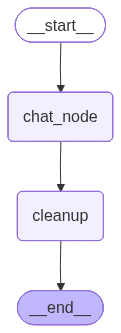

In [8]:
graph

In [9]:
config = {"configurable": {"thread_id": "t1"}}

In [10]:
# Run multiple times
graph.invoke({"messages": [{"role": "user", "content": "Hi, My name is Shreyas"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Tell me about LangGraph"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "Now explain checkpointers"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Langchain"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Quantum Mechanics"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is Gen AI"}]}, config)
graph.invoke({"messages": [{"role": "user", "content": "What is my name"}]}, config)

{'messages': [HumanMessage(content='What is Langchain', additional_kwargs={}, response_metadata={}, id='5b099b8a-934e-4d48-b8af-0340cf4a1a2b'),
  AIMessage(content='I\'m not sure what you mean by "Langchain." It could be a term or concept related to language, technology, or some other field. If you can provide more context or clarify your question, I\'d be happy to try and help you understand or find information on the topic.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 315, 'total_tokens': 373, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CzmwX4792ae6BsKi8uefzmLRoscfM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run-

In [11]:
snap = graph.get_state(config)
print("Stored messages after cleanup:", len(snap.values["messages"]))

Stored messages after cleanup: 8


### We have 8 messages because:
1) The graph is invoked 7 times, so we'll get 14 messages (7 user and 7 AI)
2) The cleanup node removes the first 6 messages